In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train_ZoGVYWq.csv")
test = pd.read_csv("../data/test_66516Ee.csv")
submission = pd.read_csv("../data/sample_submission_sLex1ul.csv")

# Setup Data

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [4]:
#SETUP DATA
data = pd.concat([train, test], axis=0).reset_index(drop = True)
data["sourcing_channel"] = LabelEncoder().fit_transform(data["sourcing_channel"])
data["residence_area_type"] = LabelEncoder().fit_transform(data["residence_area_type"])

In [5]:
train = data[:train.shape[0]].reset_index(drop =True)
test = data[train.shape[0]:].reset_index(drop =True)

train_id = train[["id"]]
test_id = test[["id"]]
target = train.renewal

train = train.drop(["id","renewal"], axis=1)
test = test.drop(["id","renewal"], axis=1)

# Running  Model

In [6]:
import lightgbm as lgb
def model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train,categorical_feature = ["sourcing_channel","residence_area_type"])
    dval = lgb.Dataset(x_test, label=y_test, categorical_feature = ["sourcing_channel","residence_area_type"])
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 1,
        "metric":"auc",
        "objective": "binary",
        "learning_rate":0.15,
        "num_leaves":5,
        "max_depth":5,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 241232332,
        "seed":233333112
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))
    
    global meta_train_tid
    meta_train_tid[train_index] = model.predict(x_train, num_iteration=model.best_iteration or 5000)

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [7]:
meta_train = np.zeros(train.shape[0])
meta_train_tid = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=123233)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", roc_auc_score(target, meta_train)

test_id["renewal"] = pd.DataFrame(np.array(meta_test).T).rank(pct = True, axis=0).mean(axis=1)
train_id["renewal"] = meta_train
train_id["renewal_tid"] = meta_train_tid

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.851666	valid_1's auc: 0.847935
[200]	training's auc: 0.862105	valid_1's auc: 0.847269
Early stopping, best iteration is:
[60]	training's auc: 0.845999	valid_1's auc: 0.848459
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.856948	valid_1's auc: 0.830025
[200]	training's auc: 0.865416	valid_1's auc: 0.829262
Early stopping, best iteration is:
[98]	training's auc: 0.856519	valid_1's auc: 0.830235
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.85365	valid_1's auc: 0.839999
[200]	training's auc: 0.862378	valid_1's auc: 0.838862
[300]	training's auc: 0.869007	valid_1's auc: 0.837874
Early stopping, best iteration is:
[106]	training's auc: 0.854296	valid_1's auc: 0.840201
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.853775	valid_1's auc: 0.843739
[200]	training's auc: 0.862988	valid_1's 

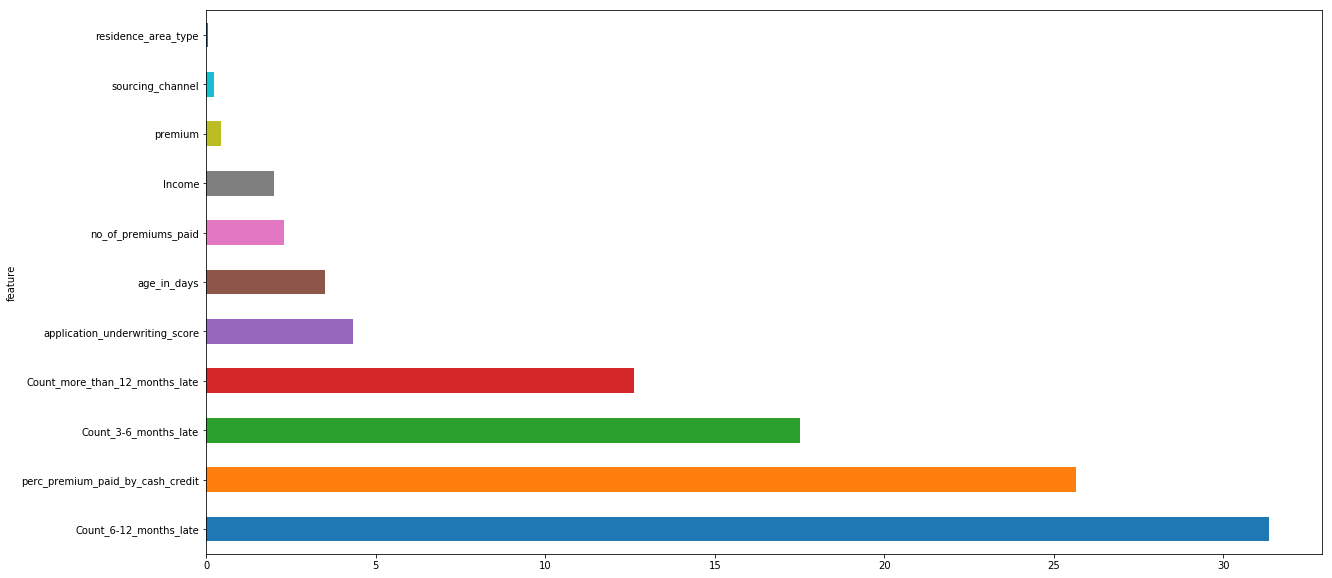

In [8]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


# Working on Incentives

In [9]:
def get_effort(incentive):
    return 10*(1-np.exp(-incentive/400.0))
    
def get_improvement_in_renewal_probability(incentive):
    effort = get_effort(incentive)
    return 20*(1-np.exp(-effort/5.0))

def gradient_improvement_in_renewal_probability(incentive):
    dpde = 4 * np.exp(-get_effort(incentive)/5.0)
    dedi = np.exp(-incentive/400.0)/40.0
    dpdi = dpde * dedi
    return  dpdi
    
def revenue_score(incentive, benchmark, premium):
    cdp = get_improvement_in_renewal_probability(incentive)
    profits = ((benchmark + (cdp*benchmark/100.0)) * premium)-incentive
    return np.sum(profits)

def score_gradient(incentive, benchmark, premium):
    z=  np.exp(-incentive/400.0)-(incentive/400.0)-2
    return ((benchmark * premium * np.exp(z)/400.0)-1)

def second_score_gradient(incentive, benchmark, premium):
    a = np.exp(-incentive/400.0)-(incentive/400.0)
    b = (benchmark* premium* np.exp(a))/400.0
    return (-(b)-(1.0/400.0))/400.0

def learn(benchmark, premium, early_stopping = 5, start_incentive = 1700, min_improvement = 0.005, verbose = True):
    incentive = start_incentive
    best_incentive = start_incentive
    
    score = 0
    best_score = 0
    
    counter = 0
    best_counter = 0
    no_improvement_counter = 0
    
    while True:
        lr = (incentive - 0)
        gradient = score_gradient(incentive, benchmark, premium)
        try:
            incentive += lr*(gradient*0.5 + 0.5*prev_gradient)
        except:
            incentive += lr*gradient
            
        
        score = revenue_score(incentive, benchmark, premium)
        counter +=1
        prev_gradient = gradient

        if (score-best_score> min_improvement):
            best_score = score
            best_incentive = incentive
            best_counter = counter
            
            no_improvement_counter = 0
            if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
        else:
            if (no_improvement_counter > early_stopping):
                if verbose: print "Early Stopping, Best Iteration Round: {}".format(best_counter)
                return best_incentive, best_score
            else:
                no_improvement_counter +=1
                if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
    

In [10]:
def annealing(benchmark, premium, num_annealing = 30):
    results = []
    for incentive in range(0,premium,int(float(premium)/num_annealing)):
        results.append(learn(benchmark, premium, early_stopping = 5, start_incentive = incentive, min_improvement = 0.005, verbose = False))
    return sorted(results, key = lambda x: x[1])[-1][0]    

In [11]:
train_incentives = []

for i, (benchmark, premium) in enumerate(zip(train_id["renewal_tid"], train["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    train_incentives.append(annealing(benchmark, premium))
    
train_incentives = pd.Series(train_incentives)
train_incentives[train_incentives<0] = 0

generated_score = revenue_score(train_incentives, train_id["renewal_tid"], train["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(train_incentives)), train_id["renewal_tid"], train["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Completed 40000 Rows
Completed 50000 Rows
Completed 60000 Rows
Completed 70000 Rows
Score using generated Incentive: 917215230.287
Score using 1650 as Incentive: 834737600.695
Score Improvement: 1.09880665436


In [12]:
test_incentives = []

for i, (benchmark, premium) in enumerate(zip(test_id["renewal"], test["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    test_incentives.append(annealing(benchmark, premium))
    
test_incentives = pd.Series(test_incentives)
test_incentives[test_incentives<0] = 0

generated_score = revenue_score(test_incentives, test_id["renewal"], test["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(test_incentives)), test_id["renewal"], test["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Score using generated Incentive: 215290856.021
Score using 1650 as Incentive: 173497042.452
Score Improvement: 1.24089063985


# Training for Incentives

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 1,
        "metric":"rmse",
        "objective": "regression",
        "learning_rate":0.05,
        "num_leaves":10,
        "max_depth":10,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 1313,
        "seed":4232
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [14]:
train["prediction"] = train_id["renewal"]
test["prediction"] = train_id["renewal"]

meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=3245)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_incentives[train_index], train_incentives[test_index]

    model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", mean_squared_error(train_incentives, meta_train)
test_id["incentives"] = np.array(meta_test).T.mean(axis=1)
train_id["incentives"] = meta_train

test_id["incentives"] += test_incentives
test_id["incentives"] /= 2

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 11.4043	valid_1's rmse: 11.1474
[200]	training's rmse: 8.88255	valid_1's rmse: 8.82898
[300]	training's rmse: 8.27847	valid_1's rmse: 8.4942
[400]	training's rmse: 7.93006	valid_1's rmse: 8.32484
[500]	training's rmse: 7.69292	valid_1's rmse: 8.19907
[600]	training's rmse: 7.49153	valid_1's rmse: 8.12181
[700]	training's rmse: 7.29909	valid_1's rmse: 8.07243
[800]	training's rmse: 7.13363	valid_1's rmse: 8.03414
[900]	training's rmse: 6.98385	valid_1's rmse: 7.99528
[1000]	training's rmse: 6.85757	valid_1's rmse: 7.96932
[1100]	training's rmse: 6.73214	valid_1's rmse: 7.95164
[1200]	training's rmse: 6.61256	valid_1's rmse: 7.92153
[1300]	training's rmse: 6.49987	valid_1's rmse: 7.91309
[1400]	training's rmse: 6.39482	valid_1's rmse: 7.88674
[1500]	training's rmse: 6.30143	valid_1's rmse: 7.8705
[1600]	training's rmse: 6.2176	valid_1's rmse: 7.86132
[1700]	training's rmse: 6.13922	valid_1's rmse: 7.843

[3900]	training's rmse: 4.87589	valid_1's rmse: 8.39746
[4000]	training's rmse: 4.84361	valid_1's rmse: 8.38919
[4100]	training's rmse: 4.80763	valid_1's rmse: 8.39357
[4200]	training's rmse: 4.77152	valid_1's rmse: 8.38964
[4300]	training's rmse: 4.73655	valid_1's rmse: 8.38619
[4400]	training's rmse: 4.69946	valid_1's rmse: 8.38646
[4500]	training's rmse: 4.66625	valid_1's rmse: 8.38417
[4600]	training's rmse: 4.63205	valid_1's rmse: 8.38573
Early stopping, best iteration is:
[4461]	training's rmse: 4.68027	valid_1's rmse: 8.38312
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 11.3963	valid_1's rmse: 11.4045
[200]	training's rmse: 8.91156	valid_1's rmse: 9.05408
[300]	training's rmse: 8.28896	valid_1's rmse: 8.6525
[400]	training's rmse: 7.93273	valid_1's rmse: 8.47674
[500]	training's rmse: 7.6648	valid_1's rmse: 8.35564
[600]	training's rmse: 7.44994	valid_1's rmse: 8.25652
[700]	training's rmse: 7.269	valid_1's rmse: 8.21326
[800]	training's 

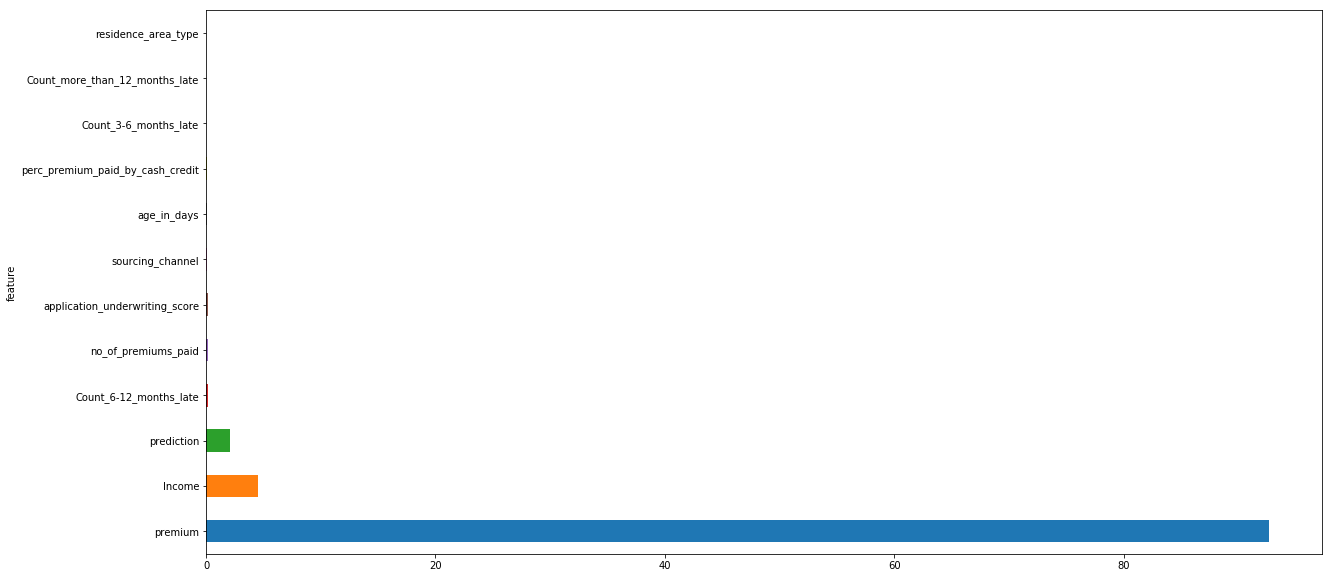

In [15]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


In [16]:
submission = submission[["id"]].merge(test_id[["id","renewal","incentives"]], how = "left", on = "id")
submission = submission[["id", "renewal", "incentives"]]
submission.loc[submission.incentives < 0,"incentives"] = 0
submission.to_csv("csv/eda6.csv", index=False)

In [17]:
submission

id   renewal  incentives
0         649  0.950362  177.172740
1       81136  0.692096  401.836144
2       70762  0.148592  207.007911
3       53935  0.495366  209.642674
4       15476  0.374369  296.466768
5       64797  0.732132  400.265598
6       67412  0.096722   80.290204
7       44241  0.084601   92.276253
8        5069  0.891947  467.226291
9       16615  0.934724  662.118535
10      84281  0.802320  551.789361
11      82623  0.431294    9.501397
12      86475  0.024404  190.173803
13      68263  0.305382    9.830652
14     113135  0.313318    6.598844
15      45532  0.392532  428.489171
16     102161  0.984222  341.429932
17      84789  0.034549  337.293326
18      62398  0.508640  369.257104
19      70148  0.695740  141.167460
20     102487  0.199480  313.706006
21     100513  0.201224  281.380057
22      92702  0.166345  138.937215
23      25051  0.036860  156.863064
24      92920  0.900465  469.122158
25      25520  0.382241  340.742771
26      81869  0.394743  643.333663
27      75402  0.695120  303.596847
28      34053  0.025935    3.913535
29      21191  0.772350  368.611091
...       ...       ...         ...
34194   79950  0.694922  294.098951
34195   30272  0.826221   12.029576
34196   85914  0.994846  482.643874
34197   10922  0.762079  449.620804
34198   93046  0.747031  230.496427
34199   52826  0.316851  417.928706
34200   35994  0.746838  668.916117
34201    1512  0.768347  248.899429
34202   52077  0.439899  251.721088
34203   95749  0.592634  286.277040
34204   49946  0.721745  151.402557
34205   66811  0.649261  352.132924
34206   53438  0.926628   15.459702
34207   24435  0.715089  539.172390
34208   17848  0.498001  387.378162
34209   53626  0.613239  228.090894
34210   87268  0.923162  475.042740
34211   58450  0.569770    9.677907
34212   48188  0.699495  585.640217
34213   44239  0.484356  361.283053
34214   24582  0.263155  215.049551
34215   79939  0.377276  101.269315
34216   63759  0.423960   11.319369
34217   63725  0.037970   80.836539
34218   37116  0.413599  482.920311
34219   81988  0.447458  196.196343
34220   30326  0.591158    6.285729
34221   65749  0.347733    9.541670
34222   65686  0.048714  229.141229
34223   93826  0.364925  161.215864

[34224 rows x 3 columns]